In [1]:
import os
os.environ["KERAS_BACKEND"] = 'tensorflow'

import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops


url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"
local_zip_path = "PeMSD7_Full.zip"

zip_path = keras.utils.get_file(fname=local_zip_path, origin=url, extract=True, archive_format="zip", cache_dir="." )

extracted_path = os.path.join(".", "datasets", "PeMSD7")
print((extracted_path))

In [28]:
csv_path = "datasets/PeMSD7_Full_extracted/PeMSD7_W_228.csv"
route_distances = pd.read_csv(csv_path, header=None)

csv_path1 = "datasets/PeMSD7_Full_extracted/PeMSD7_V_228.csv"
speeds_array = pd.read_csv(csv_path1, header=None).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


In [29]:
route_distances.tail()

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
223,21561.83,20115.08,19981.55,19351.79,20308.62,19511.11,19071.76,20213.28,20588.91,19083.19,...,3290.11,11723.54,13522.90,14893.28,11497.89,0.00,12631.46,1094.37,4919.10,12631.46
224,10012.42,9915.24,13057.44,14634.38,12718.08,20016.37,18818.51,9494.37,11861.80,17280.23,...,9344.11,910.65,891.79,2261.85,1136.11,12631.46,0.00,13725.79,17550.36,0.00
225,22614.08,21118.47,20827.51,20075.57,21186.77,19835.97,19470.62,21237.34,21522.07,19606.70,...,4384.20,12817.80,14617.24,15987.60,12592.15,1094.37,13725.79,0.00,3825.01,13725.79
226,26339.90,24716.98,23992.78,22897.82,24440.57,21457.04,21329.55,24890.70,24927.73,21843.90,...,8207.13,16642.60,18441.71,19812.20,16416.96,4919.10,17550.36,3825.01,0.00,17550.36
227,10012.42,9915.24,13057.44,14634.38,12718.08,20016.37,18818.51,9494.37,11861.80,17280.23,...,9344.11,910.65,891.79,2261.85,1136.11,12631.46,0.00,13725.79,17550.36,0.00


In [30]:
route_distances=route_distances.to_numpy()

In [32]:
sample_routes = [  0,    1,    4,    7,    8,    11,    15,
    108,    109,    114,    115,    118,    120,    123,    124,
    126,    127,    129,    130,    132,    133,    136,    139,
    144,    147,    216,]

In [33]:
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]
print(f"route_distance shapes={route_distances.shape}")
print(f"speed_array shape={speeds_array.shape}")

route_distance shapes=(26, 26)
speed_array shape=(12672, 26)


# data visualization

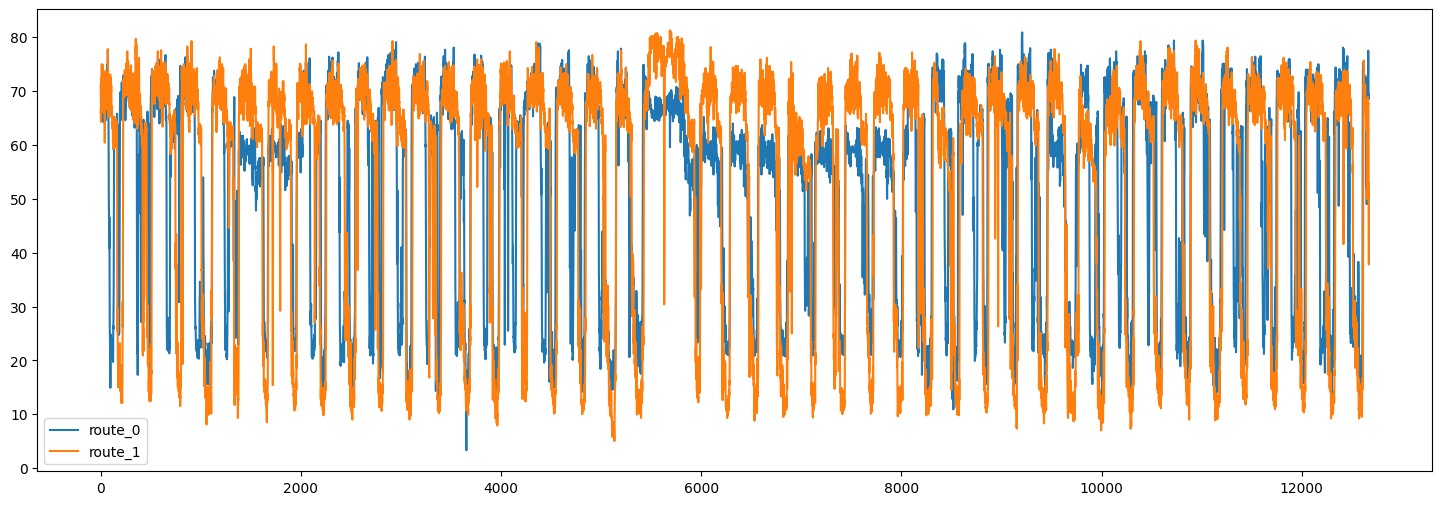

In [40]:
plt.figure(figsize=(18,6))
plt.plot(speeds_array[:,[0,1]])
plt.legend(["route_0","route_1"])

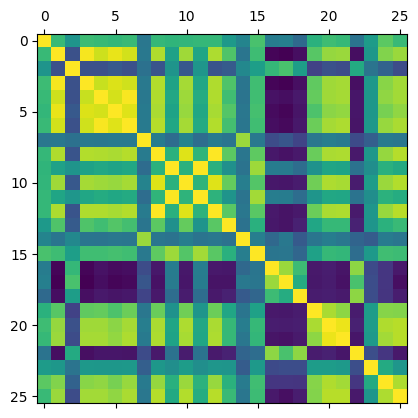

In [41]:
plt.matshow(np.corrcoef(speeds_array.T),0)

# splitting and normalizing

In [44]:
train_size, val_size = 0.5, 0.2

def preprocess(data_array: np.ndarray,   train_size: float,    val_size: float):

    """splits data in train/val/test sets and normalizes the data.
  
    Args:
         data_array: ndarray of shape `(num_time_steps, num_routes)`
         train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
         val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
         `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )

    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

In [45]:
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


In [ ]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forcast_horizon: int,
    batch_size: int = 128,
    shuffle = True,
    multi_horizon = True,
):
    